In [1]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os

In [3]:
def copy_usr_loc(Users1, Users2):
    
    for u in range(len(Users1)):
        Users2[u].usr_place = Users1[u].usr_place
        Users2[u].expected_time_true = Users2[u].get_expected_time()
        
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
# System Parameters
T = 5000
num_users = 10
num_svrs = 16
num_locs = 16
mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
ceilings = [2,5,10,20, 40]
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
space_1d_dim = 10 #4 for small, 10 for big

num_explore = 1
trials = 1

# result dictionaries
result_dicts = []
performance_list = []
user_dicts = []

save_name = 'results/ceiling_sweep/'
isExist = os.path.exists(save_name)
if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(save_name)

for tri in range(trials):
    
    print("trial:", tri)
    result_dict = {}
    user_dict = {}
    
    # Generate visitng locations and server locations
    usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs)
    svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs)

    # Create Users
    Users = []
    for i in range(num_users):
        Users += [User(usr_locs,svr_locs,mu[i],i,
                      max_dist = 7, threshold_dist = 6, self_weight = 1 - 0.95, P = None, ceiling = 1,
                      sticky_mode = True, kick_mode=True)]

    # Create Servers
    Servers = []
    for i in range(num_svrs):
        Servers += [Server(svr_locs[i],mu,i)]

    # Recorded Values - reservation
    regret = np.zeros(T)
    collision_count = np.zeros(T)
    optimal_reward = np.zeros(T)

    # Explore rounds are common/shared across all users
    explore_rounds(Users, num_users, Servers, mu, regret, collision_count, optimal_reward,
                   usr_move_flag = True, rounds=num_explore)

    
    # Make copies of values for worst case
    Users_2 = copy.deepcopy(Users)
    regret_2 = copy.deepcopy(regret)
    collision_count_2 = copy.deepcopy(collision_count)
    for u in Users_2:
        u.ceiling = 2
        u.expected_time_true = u.get_expected_time()
    
    # Make copies of values for worst case
    Users_5 = copy.deepcopy(Users)
    regret_5 = copy.deepcopy(regret)
    collision_count_5 = copy.deepcopy(collision_count)
    for u in Users_5:
        u.ceiling = 5
        u.expected_time_true = u.get_expected_time()
        
    # Make copies of values for worst case
    Users_10 = copy.deepcopy(Users)
    regret_10 = copy.deepcopy(regret)
    collision_count_10 = copy.deepcopy(collision_count)
    for u in Users_10:
        u.ceiling = 10
        u.expected_time_true = u.get_expected_time()
        
    Users_20 = copy.deepcopy(Users)
    regret_20 = copy.deepcopy(regret)
    collision_count_20 = copy.deepcopy(collision_count)
    for u in Users_20:
        u.ceiling = 20
        u.expected_time_true = u.get_expected_time()
        
    Users_40 = copy.deepcopy(Users)
    regret_40 = copy.deepcopy(regret)
    collision_count_40 = copy.deepcopy(collision_count)
    for u in Users_40:
        u.ceiling = 40
        u.expected_time_true = u.get_expected_time()
        
    round_start = ((num_svrs)*num_explore)+1
    for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
        w = obtain_w(Users, len(Users), len(Servers))
        optimal = offline_optimal_action(w, mu)
        optimal_reward[t] = optimal[1]
        play_round(Users, Servers, mu, regret, collision_count, 
                   usr_move_flag = True, debugger = False, reservation_mode = True, optimal =optimal)
        play_round(Users_2, Servers, mu, regret_2, collision_count_2, 
                   usr_move_flag = False, debugger=False, reservation_mode = True, optimal=optimal)
        play_round(Users_5, Servers, mu, regret_5, collision_count_5, 
                   usr_move_flag = False, debugger=False, reservation_mode = True, optimal=optimal)
        play_round(Users_10, Servers, mu, regret_10, collision_count_10, 
                   usr_move_flag = False, debugger=False, reservation_mode = True, optimal=optimal)
        play_round(Users_20, Servers, mu, regret_20, collision_count_20, 
                   usr_move_flag = False, debugger=False, reservation_mode = True, optimal=optimal)
        play_round(Users_40, Servers, mu, regret_40, collision_count_40, 
                   usr_move_flag = False, debugger=False, reservation_mode = True, optimal=optimal)
        copy_usr_loc(Users, Users_2)
        copy_usr_loc(Users, Users_5)
        copy_usr_loc(Users, Users_10)
        copy_usr_loc(Users, Users_20)
        copy_usr_loc(Users, Users_40)

    # Obtain reward values
    reward = optimal_reward - regret
    reward_2 = optimal_reward - regret_2
    reward_5 = optimal_reward - regret_5
    reward_10 = optimal_reward - regret_10
    reward_20 = optimal_reward - regret_20
    reward_40 = optimal_reward - regret_40
    threshold = 1

    
    # Log results
    result_dict["reward_1"] = reward
    result_dict["reward_2"] = reward_2
    result_dict["reward_5"] = reward_5
    result_dict["reward_10"] = reward_10
    result_dict["reward_20"] = reward_20
    result_dict["reward_40"] = reward_40
    
    result_dict["regret_1"] = regret
    result_dict["regret_2"] = regret_2
    result_dict["regret_5"] = regret_5
    result_dict["regret_10"] = regret_10
    result_dict["regret_20"] = regret_20
    result_dict["regret_40"] = regret_40
    
    result_dict["collision_1"] = collision_count
    result_dict["collision_2"] = collision_count_2
    result_dict["collision_5"] = collision_count_5
    result_dict["collision_10"] = collision_count_10
    result_dict["collision_20"] = collision_count_20
    result_dict["collision_40"] = collision_count_40
    
    # Store values
#     user_dict['1'] = Users
#     user_dict['2'] = Users_2
#     user_dict['5'] = Users_5
#     user_dict['10'] = Users_10
#     user_dict['20'] = Users_20
#     user_dict['40'] = Users_40
    
#     result_save_name = save_name + 'regret_trial' + str(tri) + '.p'
#     with open(result_save_name, 'wb') as handle:
#         pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#     user_save_name = save_name + 'user_trial' + str(tri) + '.p'
#     with open(user_save_name, 'wb') as handle:
#         pickle.dump(user_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
#     user_dicts += [user_dict]
    result_dicts += [result_dict]

trial: 0


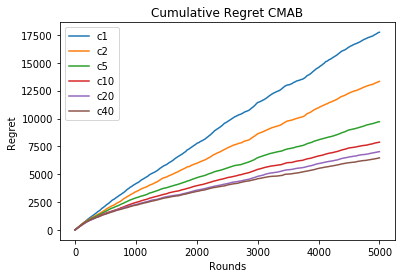

In [5]:
# Make plots of average
b = result_dicts

regret_1_avg = np.zeros(T)
regret_2_avg = np.zeros(T)
regret_5_avg = np.zeros(T)
regret_10_avg = np.zeros(T)
regret_20_avg = np.zeros(T)
regret_40_avg = np.zeros(T)

for i in range(trials):
    regret_1_avg += 1/trials * b[i]['regret_1']
    regret_2_avg += 1/trials * b[i]['regret_2']
    regret_5_avg += 1/trials * b[i]['regret_5']
    regret_10_avg += 1/trials * b[i]['regret_10']
    regret_20_avg += 1/trials * b[i]['regret_20']
    regret_40_avg += 1/trials * b[i]['regret_40']
    
plt.plot(np.cumsum(regret_1_avg), label = 'c1')
plt.plot(np.cumsum(regret_2_avg), label = 'c2')
plt.plot(np.cumsum(regret_5_avg), label = 'c5')
plt.plot(np.cumsum(regret_10_avg), label = 'c10')
plt.plot(np.cumsum(regret_20_avg), label = 'c20')
plt.plot(np.cumsum(regret_40_avg), label = 'c40')


plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.legend()

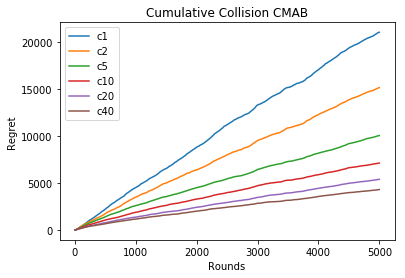

In [6]:
# Make plots of average
b = result_dicts

regret_1_avg = np.zeros(T)
regret_2_avg = np.zeros(T)
regret_5_avg = np.zeros(T)
regret_10_avg = np.zeros(T)
regret_20_avg = np.zeros(T)
regret_40_avg = np.zeros(T)

for i in range(trials):
    regret_1_avg += 1/trials * b[i]['collision_1']
    regret_2_avg += 1/trials * b[i]['collision_2']
    regret_5_avg += 1/trials * b[i]['collision_5']
    regret_10_avg += 1/trials * b[i]['collision_10']
    regret_20_avg += 1/trials * b[i]['collision_20']
    regret_40_avg += 1/trials * b[i]['collision_40']

    
plt.plot(np.cumsum(regret_1_avg), label = 'c1')
plt.plot(np.cumsum(regret_2_avg), label = 'c2')
plt.plot(np.cumsum(regret_5_avg), label = 'c5')
plt.plot(np.cumsum(regret_10_avg), label = 'c10')
plt.plot(np.cumsum(regret_20_avg), label = 'c20')
plt.plot(np.cumsum(regret_40_avg), label = 'c40')


plt.title('Cumulative Collision CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.legend()

In [7]:
Users_5[5].expected_time_true

5

In [17]:
np.sum(Users[5].history_collisions)/5000

0.4344

In [18]:
np.sum(Users_40[5].history_collisions)/5000

0.0688

In [19]:
Users_40[5].expected_time_true

19.0